# Topography at the inner core boundary

Without external motions in the solid inner core (convective instabilities or flows induced by external forces such as due to magnetic field), the topography at the inner core boundary (ICB) is set by the equilibrium between viscous relaxation of the topography and the freezing/melting at the ICB that induce a topography. 

Viscous relaxation tends to flatten the ICB, while building of the topography is due, for example, to lateral variation of growth rate. Lateral variations of the temperature in the outer core are considered of the order of $10^{-3}$ K (find a reference) because of the highly turbulent flow in the liquid metal. However, lateral variations of heat flux are considered larger. The large scale variations have in fact been proposed as the main driving forces for inner core flows in the case of no-convection (Yoshida, Deguen), giving velocities larger than any other proposed mechanisms for viscosities larger than $10^{14}$ Pa.s (Lasbleis). In this case, the degree 2 heat flux variation induces a degree 2 variation (TO DO : check degree 2?) in  the growth rate, which is viscously relaxed in the bulk of the inner core. As these studies focused on large scale flows in the bulk of the inner core, small scales variation of the heat flux were not considered. Given the turbulent flow in the outer core, small scales variations of the heat fluxes are in fact considered highly random, contrary to the equatorial/pole variations due to the organisation of the flow in the outer core in Taylor columns aligned with the rotation axis. 

Here, we proposed to estimate the topography induced by smal scale variations of the heat flux, considering that such variations are randomly determined by a Markoff process with a given correlation time. 

In [1]:
%matplotlib inline

import theano  #to generate and deal with lots of parallel path (ideal for looking at statistics!)
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
import numpy as np
import matplotlib.pyplot as plt
import time

from stochasticequationsolver import StochasticEquationSolver

### Class model, generic class for solving stochastic equations.
Define the schemes for integration (Euler and Runge Kutta order 4)

This is available in the file stochasticequationsolver.py. Please refer to this file for the solver and side functions. 

Here, we first start by studying a few very simple cases, to be sure that the results of the numerical integration are corrects. First example: bistable genetic, second example: Wiener equation (only white noise)

## Examples for solving a stochastic equation : bistable genetic

This has been adapted from http://www.nehalemlabs.net/prototype/blog/2013/10/17/solving-stochastic-differential-equations-with-theano/

We solve the ode function : dc/dt  = f(c, lambda)+c*w(t) (c is a vector with m components, the number of samples chosen)

Here, f(c, lambda)= c^n/(c^n +k^n) - lambda c

In [2]:
class BistableGenetic(StochasticEquationSolver):
    
    def __init__(self, n, k, l):
        StochasticEquationSolver.__init__(self)
        self.name = "Bistable genetic"
        self.n = n
        self.k = k
        self.l =l
        
    def g(self, c):
        """ Corresponds to the function G in the Ito's equation dy = f(y,t)dt + G(y,t)dW """
        return c
        
    def evolve(self,c):
        return T.pow(c, self.n)/(T.pow(c, self.n)+T.pow(self.k,self.n)) - self.l*c


running sim...
done in 0.596437 s at  5.96437e-06 s per path


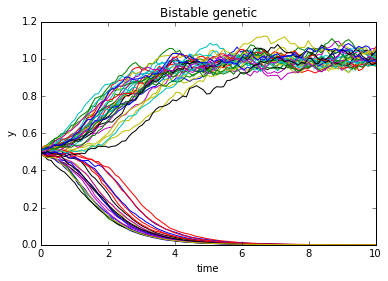

In [3]:
#define numeric variables
num_samples = 100000
n0 = 6
k0 = 0.5
l0 = 1/(1+np.power(k0, n0))
dt0 = 0.1
total_time = 10
total_steps = int(total_time/dt0)

model = BistableGenetic(n0, k0, l0)
model.init_run(num_samples, dt0, total_time, 0.5)

model.run()
model.plot_series()

## Random walk

### Definition of the subclass

In [4]:
class RandomWalk(StochasticEquationSolver):
    def __init__(self, seed=1324):
        StochasticEquationSolver.__init__(self)
        self.name = "Random Walk"
    def evolve(self,c):
        return np.zeros_like(c)
    def g(self, c):
        return 1.
    
    def mean_ensemble_old(self, index):
        """ index is the time index up to where the mean is computed."""
        downsample_factor_t = int(0.1/self.dt0)
        x = np.linspace(0, index, index)/self.total_steps*downsample_factor_t*total_time #vector time
        mean = (np.sum(self.cout[0:index:downsample_factor_t, :], axis=1)/self.num_samples)
        print "Average over realisations and paths: ", np.sum(mean)/len(mean)
        plt.subplot()
        plt.plot(x, mean)
        return np.sum(mean)/len(mean)
        
    def mean_alongpaths_old(self):
        x = np.arange(self.num_samples)+1
        mean = (np.sum(self.cout[: :], axis=0)/self.total_steps)
        print "Average over paths and realisations: ", np.sum(mean)/len(mean)
        plt.subplot()
        plt.plot(x[::200], mean[::200])
        return np.sum(mean)/len(mean)
    
    def var_ensemble_old(self, index):
        """ index is the time index up to where the mean is computed."""
        downsample_factor_t = int(0.1/self.dt0)
        x = np.linspace(0, index, index)/self.total_steps*downsample_factor_t*total_time #vector time
        mean = (np.sum((self.cout[0:index:downsample_factor_t, :])**2, axis=1)/self.num_samples)
        print "Variance over realisations and paths: ", np.sum(mean)/len(mean)
        plt.subplot()
        plt.title("Variance")
        plt.plot(x, mean)
        return np.sum(mean)/len(mean)
        
        
        
        

### Example of resolution

In [5]:
#define numeric variables
c_initial_value = 0.
num_samples = 10000
dt0 = 0.1
total_time = 100
model_run = RandomWalk(seed=3122)
model_run.init_run(num_samples, dt0, total_time, c_initial_value)

running sim...
done in 0.471144 s at  4.71144e-05 s per path


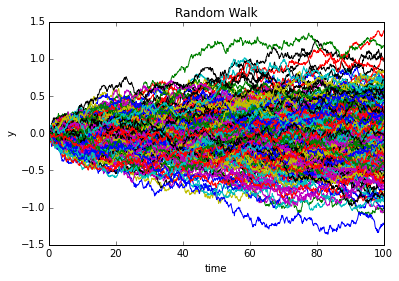

In [6]:
model_run.run()
model_run.plot_series(200)# run the simulation

#### Moyenne (sur les réalisations): 

moyenne attendue : 0.

Average over realisations and paths:  -0.0025142250061


-0.0025142250061035158

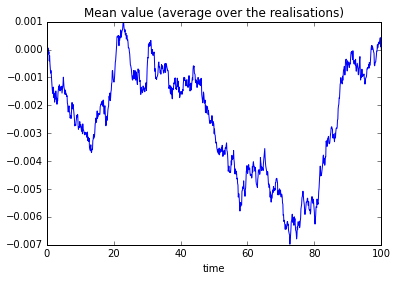

In [7]:
model_run.mean_ensemble(model_run.total_steps)

#### Moyenne du model (sur les chemins): 
moyenne attendue: $<y>=0$.

Average over paths and realisations:  -0.00251422729492


-0.0025142272949218751

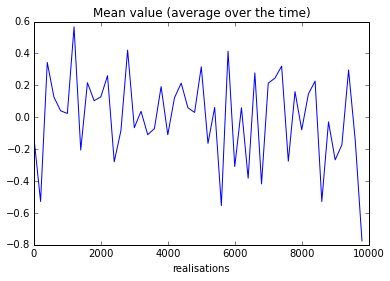

In [8]:
model_run.mean_alongpaths()

#### Variance:

$$ Var = <y^2>-<y>^2 $$

Variance attendue: $Var[y] = A^2*t$, where $A$ is the variance of the noise. 

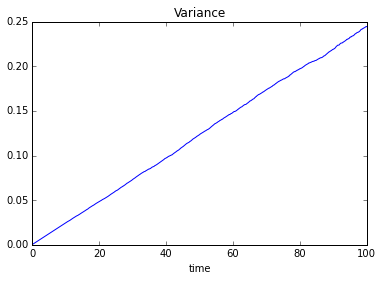

In [9]:
model_run.var_ensemble(model_run.total_steps)

## Random walk with correlation time

In [10]:
class RandomCorrelatedWalk(StochasticEquationSolver):
    def __init__(self, tau):
        StochasticEquationSolver.__init__(self)
        self.name = "Random Correlated Walk"
        self.tau = tau
    def evolve(self,c):
        return -c/tau
    def g(self,c):
        return 1.

In [11]:
c_initial_value = 0.
num_samples = 100000
dt0 = 0.1
total_time = 500
tau=50.
model = RandomCorrelatedWalk(tau)
model.init_run(num_samples, dt0, total_time, c_initial_value)

running sim...
done in 23.593149 s at  0.00023593149 s per path


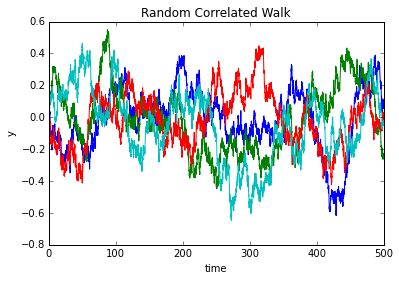

In [12]:
model.run()
model.plot_series(N=3)# run the simulation

Average over realisations and paths:  0.000582472894485


0.00058247289448499682

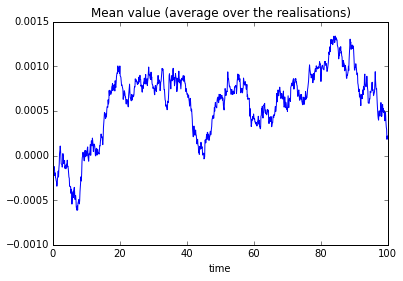

In [13]:
model.mean_ensemble(model_run.total_steps)

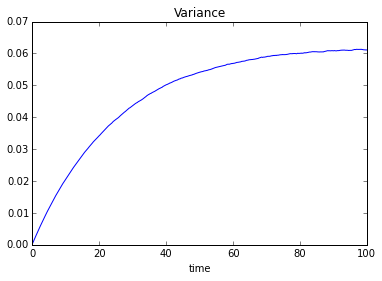

In [14]:
model.var_ensemble(model_run.total_steps)